# 5 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using Distributions
using GLM
using Plots
using StatsBase
using Statistics

In [2]:
df = CSV.read("data3a.csv");

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法
一定モデル

In [3]:
fit1 = glm(@formula(y ~ 1), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ +1

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)   2.05796 0.0357371 57.5862   <1e-99


xモデル

In [4]:
fit2 = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


### 残差逸脱度の差

In [5]:
deviance(fit1) - deviance(fit2)

4.513941078851829

### 真のモデルから100個体分のデータを新しく生成

In [6]:
df.y_rnd = rand(Poisson(mean(df.y)), 100)

100-element Array{Int64,1}:
  8
  7
  8
  9
  3
  8
  7
  7
 10
  8
  5
  6
 12
  ⋮
 12
  5
  7
 12
 11
  4
  4
  9
 10
  7
 11
 10

### 一定モデルとxモデルをこの真データに当てはめる

In [7]:
fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
deviance(fit1) - deviance(fit2)

2.470373693888675

### PB法を実行する関数
データの生成と逸脱度差の評価

In [8]:
function get_dd(df)
    n_samples = size(df, 1)
    y_mean = mean(df.y)
    df.y_rnd = rand(Poisson(y_mean), n_samples)
    fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
    fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
    deviance(fit1) - deviance(fit2)
end

get_dd (generic function with 1 method)

In [9]:
function pb(df, n_bootstrap)
    [get_dd(df) for _ in 1:n_bootstrap]
end

pb (generic function with 1 method)

### 逸脱度の差のサンプルを1000個を作成

In [10]:
dd12 = pb(df, 1000)

1000-element Array{Float64,1}:
 0.012465302576657677
 0.035931063112286665
 0.34239127420826776 
 2.3873738902448736  
 0.5558736280405014  
 0.09245487860255253 
 2.0229434227664456  
 0.3128247779316524  
 0.10178367829379908 
 0.010965166693594597
 0.5151200972789951  
 2.5453630007647945  
 4.535775060320333   
 ⋮                   
 0.6902673130294801  
 0.019754260202816454
 0.21006283082033406 
 0.9746229208311092  
 2.5480643697455463  
 0.8728076889968008  
 0.014746288213530079
 0.14741929783509988 
 0.17138144421581103 
 0.6841576787072086  
 0.5593547081290495  
 0.21804940202450496 

In [11]:
describe(dd12)

Summary Stats:
Mean:           0.965541
Minimum:        0.000002
1st Quartile:   0.085295
Median:         0.415875
3rd Quartile:   1.252693
Maximum:        11.510013
Length:         1000
Type:           Float64


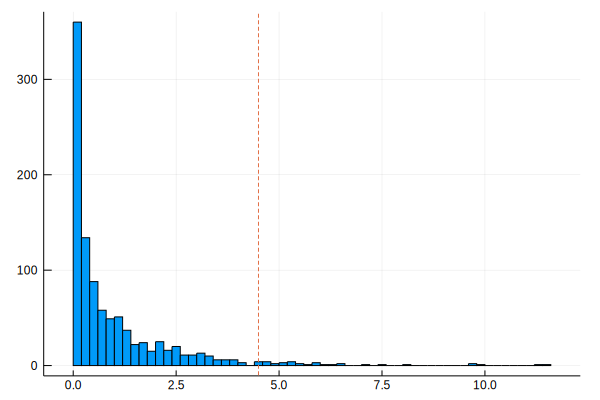

In [12]:
histogram(dd12, bins=100, label="")
plot!([4.5], seriestype=:vline, linestyle=:dash, label="")

合計1000個の$\Delta D_{1,2}$のうちいくつが4.5より右にあるか

In [13]:
sum(dd12 .>= 4.5)

32

$P=0.05$となる逸脱度の差

In [14]:
quantile(dd12, 0.95)

3.5647733354686495

### 方法(2) $\chi^2$分布を使った近似計算法

In [15]:
ccdf(Chisq(1), 4.513)

0.03363819191961954